In [1]:
from google.colab import drive
# Google Drive를 마운트합니다.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import json
import numpy as np
import random
import pandas as pd

In [3]:
train_csv_path = "/content/drive/MyDrive/Colab Notebooks/data/samsung/train.csv"

RANDOM_SEED = 18
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 데이터 불러오기
train_data = pd.read_csv(train_csv_path)
X = train_data.iloc[:,1:-1].values  # 특성 데이터
y = train_data.iloc[:,-1].values    # 타겟 데이터

# 1. 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 이상치 처리 (Z-Score를 사용하여 이상치 제거)
z_scores = np.abs(stats.zscore(X_scaled))
X_clean = X_scaled[(z_scores < 3).all(axis=1)]
y_clean = y[(z_scores < 3).all(axis=1)]

# 3. 타겟 변수 변환 (로그 변환)
y_log = np.log1p(y_clean)

# 텐서로 변환
X_tensor = torch.tensor(X_clean, dtype=torch.float32)
y_tensor = torch.tensor(y_log, dtype=torch.float32).view(-1, 1)

# 데이터셋 분할 (Train/Validation Split)
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=RANDOM_SEED)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size=11, hidden_sizes=[64, 128, 64], output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [4]:
# grid search 로 최적의 하이퍼파라미터 찾기
param_grid = {
    'hidden_sizes': [[64, 128, 64], [128, 256, 128], [32, 64, 32]],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128],
}

def train_model(hidden_sizes, learning_rate, batch_size):
    model = MLP(hidden_sizes=hidden_sizes)
    model.cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(100):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 검증 성능 계산
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    return val_loss / len(val_loader)

best_params = None
best_MSE = float('inf')
for params in ParameterGrid(param_grid):
    MSE = train_model(**params)
    print(f"Testing parameters: {params} => MSE: {MSE:.4f}")
    if MSE < best_MSE:
        best_MSE = MSE
        best_params = params

print(f'\nBest parameters: {best_params} with a MSE of {best_MSE:.4f}')
with open('3_layer_MLP_params.json', 'w') as json_file:
    json.dump(best_params, json_file)

Testing parameters: {'batch_size': 32, 'hidden_sizes': [64, 128, 64], 'learning_rate': 0.01} => MSE: 0.0006
Testing parameters: {'batch_size': 32, 'hidden_sizes': [64, 128, 64], 'learning_rate': 0.001} => MSE: 0.0007
Testing parameters: {'batch_size': 32, 'hidden_sizes': [64, 128, 64], 'learning_rate': 0.0001} => MSE: 0.0007
Testing parameters: {'batch_size': 32, 'hidden_sizes': [128, 256, 128], 'learning_rate': 0.01} => MSE: 0.0011
Testing parameters: {'batch_size': 32, 'hidden_sizes': [128, 256, 128], 'learning_rate': 0.001} => MSE: 0.0007
Testing parameters: {'batch_size': 32, 'hidden_sizes': [128, 256, 128], 'learning_rate': 0.0001} => MSE: 0.0007
Testing parameters: {'batch_size': 32, 'hidden_sizes': [32, 64, 32], 'learning_rate': 0.01} => MSE: 0.0006
Testing parameters: {'batch_size': 32, 'hidden_sizes': [32, 64, 32], 'learning_rate': 0.001} => MSE: 0.0006
Testing parameters: {'batch_size': 32, 'hidden_sizes': [32, 64, 32], 'learning_rate': 0.0001} => MSE: 0.0007
Testing paramete

Epoch 1/300, Train Loss: 0.8291, Validation Loss: 0.0189
Epoch 2/300, Train Loss: 0.0108, Validation Loss: 0.0058
Epoch 3/300, Train Loss: 0.0037, Validation Loss: 0.0022
Epoch 4/300, Train Loss: 0.0015, Validation Loss: 0.0013
Epoch 5/300, Train Loss: 0.0010, Validation Loss: 0.0010
Epoch 6/300, Train Loss: 0.0009, Validation Loss: 0.0009
Epoch 7/300, Train Loss: 0.0008, Validation Loss: 0.0010
Epoch 8/300, Train Loss: 0.0008, Validation Loss: 0.0008
Epoch 9/300, Train Loss: 0.0007, Validation Loss: 0.0008
Epoch 10/300, Train Loss: 0.0008, Validation Loss: 0.0008
Epoch 11/300, Train Loss: 0.0007, Validation Loss: 0.0008
Epoch 12/300, Train Loss: 0.0007, Validation Loss: 0.0007
Epoch 13/300, Train Loss: 0.0006, Validation Loss: 0.0010
Epoch 14/300, Train Loss: 0.0007, Validation Loss: 0.0010
Epoch 15/300, Train Loss: 0.0006, Validation Loss: 0.0007
Epoch 16/300, Train Loss: 0.0007, Validation Loss: 0.0007
Epoch 17/300, Train Loss: 0.0006, Validation Loss: 0.0007
Epoch 18/300, Train Los

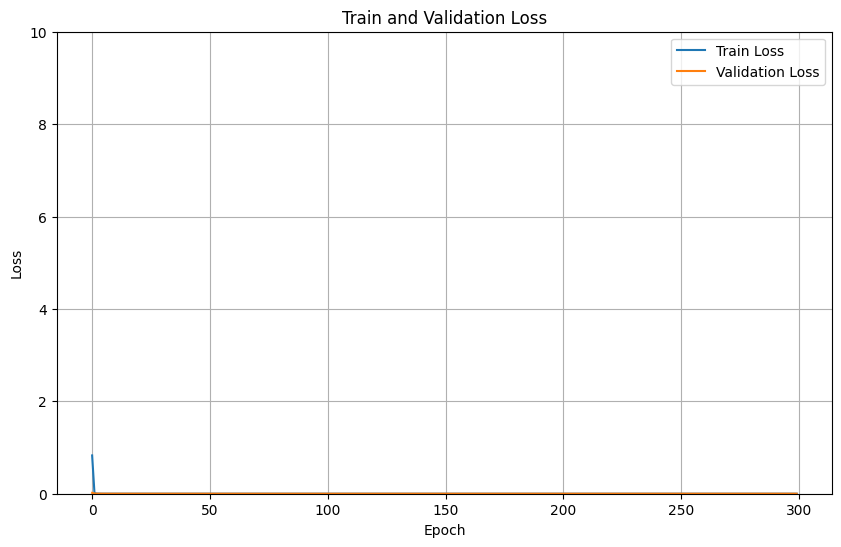

In [5]:
best_hidden_sizes = best_params['hidden_sizes']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
model = MLP(hidden_sizes=best_hidden_sizes).cuda()
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

train_losses = []
val_losses = []

for epoch in range(300):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/300, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.ylim(0, 10)  # y축 범위를 0에서 10으로 제한
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import os

test_csv_path = "/content/drive/MyDrive/Colab Notebooks/data/samsung/test.csv"

X_test = pd.read_csv(test_csv_path).iloc[:,1:].values

# 테스트 데이터에도 동일한 스케일링 적용
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

model_save_path = "model_checkpoint_epoch500.pth"
torch.save(model.state_dict(), model_save_path)

model.eval()
test_pred = []
with torch.no_grad():
    for batch in test_loader:
        batch_X = batch[0].cuda()
        outputs = model(batch_X)
        test_pred.extend(outputs.cpu().numpy())  # 예측값을 CPU로 이동하여 리스트에 추가

test_pred = np.array(test_pred).flatten()
test_pred_original_scale = np.expm1(test_pred)
# 상위 10% 임계값 계산
threshold = np.percentile(test_pred_original_scale, 90)
top_10_percent_mask = test_pred_original_scale >= threshold
from datetime import datetime

# 현재 시간을 가져와서 문자열로 변환합니다.
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# 파일 이름에 현재 시간을 포함시킵니다.
submission_csv_path = f'/content/drive/MyDrive/Colab Notebooks/data/samsung/result/MLP_3_layers_{current_time}.csv'

# 예측 결과를 저장하기 전에 디렉토리가 존재하는지 확인
if not os.path.exists(os.path.dirname(submission_csv_path)):
    os.makedirs(os.path.dirname(submission_csv_path))

# 빈 데이터프레임 생성 (또는 제출 형식에 맞게 생성)
submission_df = pd.DataFrame()
submission_df['y'] = test_pred_original_scale  # 예측 결과를 y 컬럼에 추가

# 지정된 경로에 CSV 파일로 저장
submission_df.to_csv(submission_csv_path, index=False)

In [20]:
# 상위 10% 임계값 계산
threshold = np.percentile(test_pred_original_scale, 90)
top_10_percent_mask = test_pred_original_scale >= threshold

# 결과 출력
print(f"Top 10% threshold: {threshold:.4f}")
print(f"Number of samples in top 10%: {sum(top_10_percent_mask)}")

Top 10% threshold: 91.2451
Number of samples in top 10%: 499
